# RLHF (with PPO)

In this tutorial, we'll apply RLHF (Reinforcement Learning from Human Feedback, [[Ouyang et al., 2022](https://arxiv.org/pdf/2203.02155)]) in binary preference.

In RLHF (Reinforcement Learning from Human Feedback), the following 3 steps are conducted to finetune LLM and align human preference.

- SFT (Supervised Fine-Tuning) : Firstly, LLM is trained to follow the supervised human dialogue dataset, with regular LLM training methods by minimizing cross-entropy loss for token ouputs. (See [here](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb) for regular LLM training.)
- Build a Reward Model (RM) : Using the multiple outputs of LLM, the human annotation for comparison (such as, "which answer is preferable, or not preferable") is collected, and we then build a reward model to score the outputs using this annotation dataset.
- Reward Training : With this generated reward model (RM), LLM is then trained by reinforcement learning method to maximize the reward score. In the paper, Proximal Policy Optimization (shortly, PPO) algorithm is conducted for RL method. (See [here](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb) for primitive outline about PPO.)

In this tutorial, we use [SmolLM2-Instruct (135M)](https://huggingface.co/HuggingFaceTB/SmolLM2-135M-Instruct) model (chat model) to train with existing human-preference dataset, [Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset), instead of collecting annotations from humans by myself.

> Note : SmolLM2-Instruct is also optimized by the following 2 phase fine-tuning.<br>
> 1. Supervised fine-tuning (SFT) : The model generated by pretraining phase ([SmolLM2 (135M)](https://huggingface.co/HuggingFaceTB/SmolLM2-135M)) is fine-tuned to follow chat-styled conversation by supervised fine-tuning (SFT) using [SmolTalk](https://huggingface.co/datasets/HuggingFaceTB/smoltalk) dataset.
> 2. Preference optimization : The model is then fine-tuned to generate the preferred outputs using [UltraFeedback](https://huggingface.co/datasets/HuggingFaceH4/ultrafeedback_binarized) dataset. In SmolLM2-Instruct, DPO is applied in this phase.

This dataset, [Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset) is annotated to mimic human natural, informal, and conversational interaction.<br>
Each line contains a pair of texts - one "chosen" and another "rejected". The chosen text is a preferred LLM output (more natural output) for humans, while the rejected one is a non-preferable output.

In order to reduce complexity, we don't include the following training optimization in this tutorial. :

- In the original [RLHF paper](https://arxiv.org/pdf/2203.02155), they have applied RLHF with ranked preference, but here (in this notebook) we'll apply RLHF with binary preference.
- We don't also apply the training mixture with pretrained dataset. To mitigate performance regression, pretraining mixture is often applied in practice. (See [RLHF paper](https://arxiv.org/pdf/2203.02155) or [the paper](https://arxiv.org/pdf/2204.05862) by Anthropic.)

<blockquote>
Note : According to <a href="https://arxiv.org/pdf/2204.05862">the paper</a> by Anthropic, they have conducted more meticulous RLHF steps as follows. (In this notebook, I have skipped all of these steps not to make things complex.)
<ul>
    <li>Context distillation by SFT often causes so called catastrophic forgetting, compared to the training by reinforcement learning. Not to make largely updated and overfitted, they have conducted distillation, decreasing KL divergence between base model and distilled model.</li>
    <li>A reward model (LM for reward modeling) is initialized by a special method, which is the mixed training to reduce both autoregressive LM loss on good samples and regular preference modeling (PM) loss on entire samples.</li>
    <li>To improve performance, they has also applied other methods - such as, adding "end-of-context" token at the end of each sample, etc.</li>
</ul>
</blockquote>

Now let's see the code (implementation) step-by-step with description of theoretical aspects.

Throughout this notebook, I have used pretrained model in Hugging Face, but **I manually configure and run training with regular PyTorch training loop** (i.e., won't use any built-in class in Hugging Face) not to make the implementation black-boxed.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-in-llm/))*

## Prerequisites

Before we start, we need to install the required packages.

In [ ]:
!pip install torch transformers datasets matplotlib pandas

## Prepare Dataset

Before training a model, we should prepare (preprocess) the training dataset.

In this example, we use dataset, [Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset), for training.

In [1]:
from datasets import load_dataset

all_data = load_dataset("HumanLLMs/Human-Like-DPO-Dataset")
train_data = all_data["train"]
train_data

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 10884
})

This dataset has 2 labels, "```chosen```" and "```rejected```", which is respectively a preferred response (i.e., more natural and informal response) and a non-preferred response.

In [2]:
row_num = 0
print("********** prompt **********")
print(train_data["prompt"][row_num])
print("********** chosen **********")
print(train_data["chosen"][row_num])
print("********** rejected **********")
print(train_data["rejected"][row_num])
print("********** end **********")

********** prompt **********
Oh, I just saw the best meme - have you seen it?
********** chosen **********
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣
********** rejected **********
I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?
********** end **********


Now we convert this data into the following text format, fitting for SmolLM2-Instruct inputs.<br>
In this format, the user role in chat message is "```<|im_start|>user\n...<|im_end|>```" and the assistant role in chat message is "```<|im_start|>assistant\n...<|im_end|>```".

```
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>
```

> Note : If you want to include system role, use "```<|im_start|>system\n...<|im_end|>```".

In [3]:
def format_to_chatml(example):
    return {
        "chosen": f"<|im_start|>user\n{example["prompt"]}<|im_end|>\n<|im_start|>assistant\n{example["chosen"]}<|im_end|>",
        "rejected": f"<|im_start|>user\n{example["prompt"]}<|im_end|>\n<|im_start|>assistant\n{example["rejected"]}<|im_end|>",
    }

original_columns = train_data.column_names
train_data = train_data.map(format_to_chatml, remove_columns=original_columns)

In [4]:
row_num = 0
print("********** chosen **********")
print(train_data["chosen"][row_num])
print("********** rejected **********")
print(train_data["rejected"][row_num])
print("********** end **********")

********** chosen **********
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>
********** rejected **********
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant
I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>
********** end **********


## Run Supervised Fine-tuning (SFT)

In original [RLHF](https://arxiv.org/pdf/2203.02155), the actual model's outputs are used to train model. In this example, however, we use the prepared dataset, which might be apart from the actual outputs induced by our model.<br>
When the distribution for the outputs is extremely apart from objectives, it would then be so hard to bridge this gap, because only the actual outputs are used to seek the trajectory to the goal in reinforcement learning. (See [here](https://tsmatz.wordpress.com/2025/04/21/reinforcement-learning-for-llm/).)

In this section, therefore, in order to keep the distribution of model's outputs within a certain range, we apply SFT, supervised fine-tuning (i.e., [imitation learning approach](https://tsmatz.wordpress.com/2025/04/21/reinforcement-learning-for-llm/)) using good samples, before running the optimization by reinforcement learning (RL).

Now we download [SmolLM2-Instruct (135M)](https://huggingface.co/HuggingFaceTB/SmolLM2-135M-Instruct) model and its tokenizer.

In [5]:
import torch

device = torch.device("cuda")
torch.set_default_dtype(torch.bfloat16) # because SmolLM2-Instruct is trained on bf16

In [6]:
from transformers import AutoModelForCausalLM, AutoConfig
from transformers import AutoTokenizer

base_model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"

# download model
config = AutoConfig.from_pretrained(base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    config=config,
).to(device)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

We build dataloader in order to feed data to the trainer.<br>
In SFT, we use only good samples ("```chosen```" tokens) and train on tokens of entire sequence, including both inputs and completions.

In [7]:
from torch.utils.data import DataLoader

batch_size = 4
gradient_accumulation_steps = 8

def collate_batch(batch):
    itr_batch_size = len(batch)

    # tokenize (convert to token ids and attention mask) and convert to tensor
    token_list = [item["chosen"] for item in batch]
    token_tensor = tokenizer(
        token_list,
        padding=True,
        padding_side="right",
        return_tensors="pt").to(device)

    # generate labels for SFT
    labels = token_tensor["input_ids"][:,1:].clone()
    # generate inputs for SFT
    last_nonpad_indices = token_tensor["attention_mask"].sum(dim=1) - 1  # note: valid only in right padding
    token_tensor["input_ids"][torch.arange(itr_batch_size).to(device),last_nonpad_indices] = tokenizer.pad_token_id  # note: this is not needed, because the final token is always pad token
    token_tensor["attention_mask"][torch.arange(itr_batch_size).to(device),last_nonpad_indices] = 0
    inputs = token_tensor["input_ids"][:,:-1]
    masks = token_tensor["attention_mask"][:,:-1]

    return inputs, labels, masks

dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

Now we train our base model.

> Note : In order to prevent from GPU out of memory errors, I have used accumulation training.

In [8]:
import os, math
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR
import functools

num_epochs = 1
num_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)

# prepare optimizer and scheduler
optimizer = torch.optim.AdamW(
    params=base_model.parameters(),
    lr=9.0e-6,
    betas=(0.9, 0.999),
    eps=1e-08,
)

def _get_cosine_schedule(
    current_step: int,
    num_training_steps: int,
    num_warmup_steps: int=0,
    linear_warmup: bool=False,
    min_value: float=0.0,
):
    if current_step < num_warmup_steps:
        if linear_warmup:
            return min(1.0, (current_step + 1) / (num_warmup_steps + 1))  # see https://arxiv.org/abs/2410.11020
        else:
            return 1.0
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    scale = 0.5 * (1.0 + math.cos(math.pi * progress))
    return (1.0 - min_value) * scale + min_value

scheduler = LambdaLR(optimizer, lr_lambda=functools.partial(
    _get_cosine_schedule,
    num_training_steps=num_epochs*num_steps,
    min_value=0.3,
))

# remove log file if exists
log_file = "loss_sft.log"
if os.path.exists(log_file):
    os.remove(log_file)

# iterate epoch
for epoch in range(num_epochs):
    base_model.train()
    optimizer.zero_grad()
    record_loss = []

    # iterate batch
    for i, (inputs, labels, masks) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            # get logits and values to be optimized
            outputs = base_model(
                input_ids=inputs,
                attention_mask=masks,
            )

            # compute loss
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            record_loss.append(loss.item())

            # optimize
            loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
    
            # print log
            print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - loss {loss :5.4f}", end="\r")

    # save log in epoch
    with open(log_file, "a") as f:
        for l in record_loss:
            f.write("%s\n" %l)

    print("")

# save checkpoint
### torch.save(base_model.state_dict(), "llm_sft.pt")
base_model.save_pretrained("./llm_sft")

print("Done")

Epoch 1 (iter2721) 341/341 - loss 2.2344
Done


Show loss transition in the training.

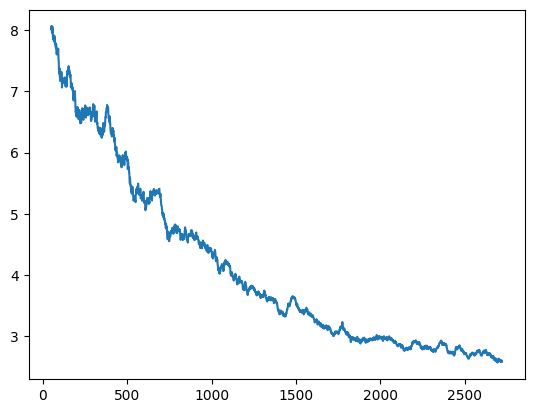

In [9]:
import matplotlib.pyplot as plt
import numpy as np

log_file = "loss_sft.log"

with open(log_file, "r") as f:
    data = [float(line) for line in f]

# show plot of every 50 interval average
interval = 50
avg = []
for i in range(interval, len(data)):
    tmp_list = data[i-interval+1:i+1]
    avg.append(np.average(tmp_list))
plt.plot(np.arange(interval, len(data)), avg)
plt.show()

## Test trained model (SFT-ed model)

In order to test our fine-tuned model, we generate outputs for the following example questions.

> Note : In this function (```generate_token_by_policy```), here we use **attention cache** for sequential token generation to speed up.<br>
> And, in order to avoid GPU memory errors in optimization, we also limit the number of tokens in sequence (by ```max_seq_len``` parameter).

In [10]:
from transformers import DynamicCache

def generate_token_by_policy(
    chat_data,
    model,
    tokenizer,
    max_seq_len,
):
    """
    Collect samples with a model (LLM) as a batch.
    To speed up generation, here we use attention cache.
    All tensors are collected with no gradient (as detached tensors).

    Parameters
    ----------
    chat_data : dic(
            input_ids: torch.tensor((batch_size, seq_len), dtype=int),
            attention_mask: torch.tensor((batch_size, seq_len), dtype=int)
        )
        Chat template data to be fed as a batch.
        The format should be left-side padding, and shouldn't include the
        final assistant's message, because it'll be generated in this function.
        (The length of input's sequence (seq_len) might differ in each call.)
    model : torch.nn.Module
        A model which is used to pick up an action (i.e., a token).
        In this function, the output is generated with no gradient.
    tokenizer : transformers.PreTrainedTokenizer
        Hugging Face tokenizer class to be used in this model.
    max_seq_len : int
        Maximum sequence length. (See above description.)

    Returns
    ----------
    completion_ids : torch.tensor((batch_size, seq_len), dtype=int)
        The array of token id for generated chat completion (including context tokens).
        The length of result's sequence (i.e., seq_len) differs depending
        on the results.
    completion_mask : torch.tensor((batch_size, seq_len), dtype=int)
        Corresponding attention mask.
    """

    # get batch size
    batch_size = chat_data["input_ids"].shape[0]

    # initialize inputs
    cur_iids = chat_data["input_ids"]
    cur_mask = chat_data["attention_mask"]

    # initialize a flag for processing/finish in a batch
    # (True: processing, False: finished)
    proceed_flag = torch.ones(batch_size, dtype=bool).to(device)

    # initialize cache parameters
    cache_position = None
    past_key_values = DynamicCache()

    # loop until all is done
    done_tokens_num = 0
    while(torch.any(proceed_flag)):
        # get current sequence length
        cur_seq_len = cur_iids.shape[1]

        # get the final non-pad token indices in sequence
        # --> shape:[batch_size]
        token_indices = torch.arange(cur_seq_len, dtype=int).to(device)
        last_nonpad_indices = (token_indices * cur_mask).argmax(-1)

        # run inference (with no gradient !)
        if cache_position is None:
            # get initial cache position
            cache_position = torch.arange(cur_seq_len, dtype=int, device=device)
            # compute logits for all input_ids
            logits = model(
                input_ids=cur_iids,
                attention_mask=cur_mask,
                cache_position=cache_position,
                past_key_values=past_key_values,
                use_cache=True,
            ).logits.detach()
            # need only final output in sequence --> shape:[batch_size, vocab_size]
            logits = logits[torch.arange(batch_size).to(device), last_nonpad_indices, :]
        else:
            # compute logits only for the last input_ids
            # (others are all cached.)
            logits = model(
                input_ids=cur_iids[:,-1:],
                attention_mask=cur_mask,
                cache_position=cache_position,
                past_key_values=past_key_values,
                use_cache=True,
            ).logits.detach()
            # reshape to [batch_size, vocab_size]
            logits = logits.squeeze(1)

        # select a token (i.e., take an action)
        # --> shape:[batch_size]
        probs = F.softmax(logits, dim=-1)
        selected_ids = torch.multinomial(probs, num_samples=1).squeeze(-1)

        # get next token indices in sequence
        # --> shape:[batch_size]
        next_token_indices = last_nonpad_indices + proceed_flag.int()

        # expand inputs when it exceeds
        # --> shape:[batch_size, cur_seq_len+1]
        if next_token_indices.max() > cur_seq_len - 1:
            cur_iids = F.pad(input=cur_iids, pad=(0, 1, 0, 0), mode="constant", value=tokenizer.pad_token_id)
            cur_mask = F.pad(input=cur_mask, pad=(0, 1, 0, 0), mode="constant", value=0)

        # store new token ids
        cur_iids[proceed_flag, next_token_indices[proceed_flag]] = selected_ids[proceed_flag]

        # store new attention mask
        cur_mask[proceed_flag, next_token_indices[proceed_flag]] = 1

        # update cache_position
        cache_position = cache_position[-1:] + 1

        # update proceed_flag
        not_lim = (cur_mask.sum(dim=1) < max_seq_len)
        is_eos = torch.logical_and((selected_ids == tokenizer.eos_token_id),proceed_flag.bool())
        not_eos = torch.logical_not(is_eos)
        proceed_flag = torch.logical_and(proceed_flag, torch.logical_and(not_lim, not_eos))

    return cur_iids, cur_mask

In [11]:
max_seq_len = 768

#
# build a batch of questions
# (To use cache, we apply left-side padding.)
#

messages = [
    "What do you most want to do right now?",
    "What is the best gift to give a friend who loves the outdoors?",
    "How do you relax after something bad happens?",
]
inputs = [f"<|im_start|>user\n{m}<|im_end|>\n<|im_start|>assistant\n" for m in messages]
input_batch = tokenizer(
    inputs,
    padding=True,
    padding_side="left",
    return_tensors="pt").to(device)
input_seq_len = input_batch["input_ids"].shape[1]

#
# generate model's outputs
#

base_model = AutoModelForCausalLM.from_pretrained("./llm_sft").to(device)
base_model.eval()

with torch.no_grad():
    iids, mask = generate_token_by_policy(
        input_batch,
        base_model,
        tokenizer,
        max_seq_len,
    )
iids = iids[:,input_seq_len:]
outputs = tokenizer.batch_decode(iids, skip_special_tokens=True)

#
# print results
#

for i in range(len(messages)):
    print("***** Question *****")
    print(messages[i])
    print("***** Answer *****")
    print(outputs[i])
    print("")

***** Question *****
What do you most want to do right now?
***** Answer *****
Where do I even start? I want to move on, to create something beautiful from scratch, something that will be a part of me for years to come. I envision a city on wheels, where every ray of light, every smile, and every crumpled up canvas flips the design over, and creates a message all its own.

I want to create a mural, something that I can still take home years from now. I want the same colors, the same pattern, and no lines. My art will be unique, with a story behind it, and a story that starts from scratch in my mind.

I also want to create a video game that responds to my emotions. I want characters that can see the light of day, identify with the gravity of the situation, and respond to my emotions in a way that feels almost organic.

And, of course, there's the dreamy, beautiful landscapes of the city I'm creating. I want the buildings, the streets, the colors, and shapes to merge into one cohesive pi

## Build a Reward Model (RM)

In reward modeling, we build a model to score outputs.

In this phase, language model (in this case, SmolLM2-Instruct) is usually used as a reward model by changing the model’s output layer from token probabilities to scalar value (reward value), because the language model has much abilities to capture language properties. (In original [RLHF paper](https://arxiv.org/pdf/2203.02155), GPT is also used for a reward model.)

### 1. Define a Reward Model

In this example, we also use fine-tuned SmolLM2-Instruct chat model for reward modeling.<br>
Firstly I'll load the fine-tuned model (which is built in the previous "SFT" section).

In [12]:
base_model = AutoModelForCausalLM.from_pretrained("./llm_sft").to(device)

SmolLM2-Instruct (135M) is based on Meta Llama and it has 30 layers in autoregressive Transformer. (See below picture.)

![SmolLM2 model (Llama)](./assets/rlhf_llama2.png)

> Note : In this architecture, the positional embedding for query and key is Rotary positional embedding.<br>
> See [here](https://github.com/meta-llama/llama/blob/llama_v2/llama/model.py) for the source code of Llama model.

In [13]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb)

The final linear layer (named "```lm_head```" in above) has the hidden features (576 tensors) as input, and the logits for all 49152 vocabularies (all 49152 tokens) as output.

In reward modeling (RM),

- We should change the final hidden linear (named "```lm_head```") to output a reward score (i.e., a single tensor).
- We then need a score **only in final token**. (Scores in other positions are disposed.)

![Reward model (RM)](./assets/rlhf_reward_model.png)

In [14]:
from torch import nn

# define model class
class RewardModel(nn.Module):
    def __init__(
        self,
        base_model,
    ):
        super().__init__()

        # replace final linear layer
        self.base_model = base_model
        self.base_model.__setattr__(
            "lm_head",
            nn.Linear(576, 1, bias=False).to(device))

    def forward(self, input_ids, attention_mask):
        output = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        ).logits

        # need only final output in sequence
        batch_size = input_ids.shape[0]
        token_indices = torch.arange(input_ids.shape[-1], dtype=int).to(device)
        last_nonpad_indices = (token_indices * attention_mask).argmax(-1)
        reward_score = output[torch.arange(batch_size).to(device), last_nonpad_indices]

        return reward_score

# generate model instance
rm = RewardModel(base_model).to(device)

In [15]:
# show how it's changes
rm

RewardModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(49152, 576, padding_idx=2)
      (layers): ModuleList(
        (0-29): 30 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(in_features=576, out_features=576, bias=False)
            (k_proj): Linear(in_features=576, out_features=192, bias=False)
            (v_proj): Linear(in_features=576, out_features=192, bias=False)
            (o_proj): Linear(in_features=576, out_features=576, bias=False)
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
            (up_proj): Linear(in_features=576, out_features=1536, bias=False)
            (down_proj): Linear(in_features=1536, out_features=576, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        )

### 2. Filter dataset

RLHF is resource-intensive, because it simultaneously needs multiple optimization during training.<br>
In order to reduce memory consumption (prevent from GPU out of memory errors), we now filter data not to exceed a certain length of tokens.

> Note : In my experiment, I have used NVIDIA Tesla T4. Depending on your environment, you can increase the maximum sequence length.<br>
> The operable maximum sequence length in ```SmolLM2-Instruct 135M``` is 8192. (See ```tokenizer.model_max_length```.)

In [16]:
# 1. add "chosen_len" and "rejected_len" column
#   (which indicates the sequence length in "chosen" and "rejected")
def add_seq_len(example):
    def get_tokenized_length(text):
        tokenized = tokenizer(text)
        return len(tokenized["input_ids"])

    chosen_len = get_tokenized_length(example["chosen"])
    reject_len = get_tokenized_length(example["rejected"])
    return {
        "chosen_len": chosen_len,
        "rejected_len": reject_len
    }

train_data = train_data.map(add_seq_len)

# 2. remove rows which exceed the maximum sequence length
train_data = train_data.filter(lambda example: example["chosen_len"] <= max_seq_len and example["rejected_len"] <= max_seq_len)
train_data = train_data.remove_columns(["chosen_len", "rejected_len"])

# show total number of filtered rows
train_data

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 10820
})

### 3. Train a reward model

Now let's train a reward model with above data.

First we build dataloader in order to feed data to the trainer.

Each input's batch is tokenized as PyTorch tensors on GPU.

It's worth noting that, in Llama family, we can use **left-side padding** for input's tokenization. Throughout our training, we then also use left-side padding.

> Note : In PPO training (in the next phase), we'll use attention cache to speed up training, and left-side padding is so useful. For this reason, we also choose the left-side padding in RM training. (The output's result will slightly differ between right-side padding and left-side padding.)

In [17]:
batch_size = 4
gradient_accumulation_steps = 8

def collate_batch(batch):
    # tokenize (convert to token ids and attention mask) and convert to tensor
    chosen_list = [item["chosen"] for item in batch]
    reject_list = [item["rejected"] for item in batch]
    chosen_tensor = tokenizer(
        chosen_list,
        padding=True,
        padding_side="left",  # see above description !
        return_tensors="pt").to(device)
    reject_tensor = tokenizer(
        reject_list,
        padding=True,
        padding_side="left",  # see above description !
        return_tensors="pt").to(device)
    return chosen_tensor, reject_tensor

dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

Now we optimize (train) a reward model.

According to [Bradley–Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model), when I denote the input context (prompt) as $x$ and the output completion as $y$, the probability $p(y_1 \succ y_2 | x)$ which means "how preferable the output $y_1$ is more than the output $y_2$ for the input $x$" is represented by the following equation. :

$\displaystyle p(y_1 \succ y_2 | x) = \frac{\exp(r(x, y_1))}{\exp(r(x, y_1)) + \exp(r(x, y_2))} \;\;\;\;\;\; (1)$

where $r(\cdot)$ is a reward function.

> Note : For multiple ranked answers (not binary preference), [Plackett-Luce ranking model](https://doi.org/10.2307/2346567) can be used.

It's worth noting that it always satisfies $ 0 \leq p(y_1 \succ y_2 | x) \leq 1 $. (The preference should not be a negative number and not larger than 1.)

> Note : In this equation, $\exp(r)$ represents a preference score, in which $\exp(r) = 1$ (i.e., $r = 0$) means that it's neutral, and $\exp(r) \approxeq 0$ (i.e., $r \ll 0$) means that it's not preferable at all. (When it's preferable, $\exp(r)$ is larger than 1.)<br>
> In Bradley–Terry equation $p_1 / (p_1 + p_2)$, both $p_1$ and $p_2$ should be a positive real-valued score, in which $p=1$ (not $p=0$) is neutral. On the contrary, the reward $r$ can be positive and negative, in which the neutral is zero.<br>
> Given partial rewards $r_1$ and $r_2$, the total preference score should be $p_1 \cdot p_2 = \exp(r_1) \cdot \exp(r_2) = \exp(r_1 + r_2)$, which means that the total reward is $r_1 + r_2$.

In order to maximize (1), now we apply a logarithm for the equation (1), and we then obtain the following preference modeling loss for each pairs of good and bad samples, $y_1$ and $y_2$. (When it's not trained at all, the mean of loss becomes ```log2 = 0.6931```.)

$\displaystyle L_{PM} = \log \left( 1 + \frac{\exp(r(x, y_2))}{\exp(r(x, y_1))} \right) \;\;\;\;\;\; (2)$

Our goal of optimization is then to minimize the loss (2).

It's worth noting that the loss value (2) becomes more smaller when the magnitude of rewards becomes greater. (When $ e^{r_2}/e^{r_1} \lt 1$, then $ e^{r_2 \cdot m}/e^{r_1 \cdot m} = (e^{r_2}/e^{r_1})^m \approxeq 0$ for arbitrary large $ m \gg 1$.)<br>
In [OpenAI implementation](https://github.com/openai/lm-human-preferences), they're adjusting a reward (which is produced by the trained model) to be normalized by $\mathcal{N}(0, 1)$ in the inference. There also exists a method in the training to give incentives to force the mean to 0.<br>
In this example, however, we don't take any adjustments for this concern.

We should also take care for [overfitting](https://tsmatz.wordpress.com/2017/09/13/overfitting-for-regression-and-deep-learning/) problems during the training. (Train with a lot variety of data and less epochs.)

> Note : In order to prevent from GPU out of memory errors, I have used accumulation training.

In [18]:
num_epochs = 1
num_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)

optimizer = torch.optim.AdamW(
    params=rm.parameters(),
    lr=3.0e-5,
    betas=(0.9, 0.999),
    eps=1e-08,
)
scheduler = LambdaLR(optimizer, lr_lambda=functools.partial(
    _get_cosine_schedule,
    num_training_steps=num_epochs*num_steps,
    num_warmup_steps=math.ceil(num_epochs*num_steps*0.1)))

# remove log file if exists
log_file = "loss_rm.log"
if os.path.exists(log_file):
    os.remove(log_file)

# iterate epoch
for epoch in range(num_epochs):
    rm.train()
    optimizer.zero_grad()
    record_loss = []

    # iterate batch
    for i, (chosen, reject) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            # get reward score (chosen)
            rewards_chosen = rm(
                input_ids=chosen["input_ids"],
                attention_mask=chosen["attention_mask"],
            )
            # get reward score (rejected)
            rewards_reject = rm(
                input_ids=reject["input_ids"],
                attention_mask=reject["attention_mask"],
            )
            # compute loss
            loss = -F.logsigmoid(rewards_chosen - rewards_reject).mean()
            loss.backward()
            # optimization by accumulation
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            # print log
            record_loss.append(loss.item())
            print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - loss {loss :5.4f}", end="\r")

    # save logging
    epoch_average_loss = sum(record_loss)/len(record_loss)
    print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - loss {epoch_average_loss :5.4f}")
    with open(log_file, "a") as f:
        for l in record_loss:
            f.write("%s\n" %l)

# save checkpoint
torch.save(rm.state_dict(), "rm.pt")

print("Done")

Epoch 1 (iter2705) 339/339 - loss 0.0464
Done


Show loss transition in the training.

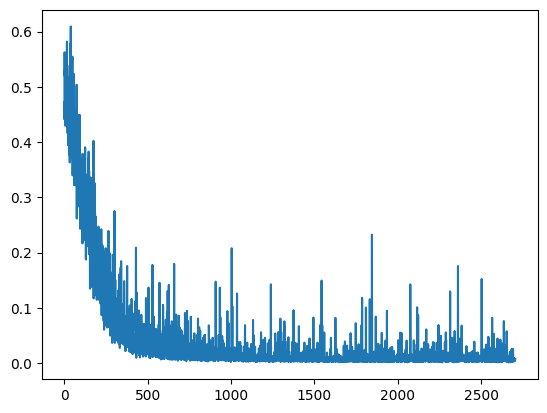

In [19]:
import matplotlib.pyplot as plt

log_file = "loss_rm.log"

with open(log_file, "r") as f:
    data = [float(line) for line in f]

plt.plot(np.arange(len(data)), data)
plt.show()

See reward scores of the following example text with a trained reward model (RM).

In [20]:
import pandas as pd

# # uncomment when you load RM from the trained checkpoint
# rm.load_state_dict(torch.load("rm.pt", weights_only=True))

rm.eval()

test_list = [
    "<|im_start|>user\nWhat do you most want to do right now?<|im_end|>\n<|im_start|>assistant\nRight now, I most want to assist you and provide helpful, respectful, and engaging interactions. If you have any questions, need information, or just want to chat, I'm here for you!<|im_end|>",
    "<|im_start|>user\nWhat do you most want to do right now?<|im_end|>\n<|im_start|>assistant\nI'd love to go for a hike in the woods! 😍 It's such a beautiful day and I really need to get some fresh air. How about you? 😊<|im_end|>",
    "<|im_start|>user\nWhat is the best gift to give a friend who loves the outdoors?<|im_end|>\n<|im_start|>assistant\nThat's a thoughtful question! Here are a few gift ideas for a friend who loves the outdoors.: High-quality Multi-tool, Reusable Water Bottle with Filter, or Portable Hammock<|im_end|>",
    "<|im_start|>user\nWhat is the best gift to give a friend who loves the outdoors?<|im_end|>\n<|im_start|>assistant\nOoh, that's a fun question!! 🙋 If you're looking for some gift ideas for a friend who loves the outdoors, I suggest National Parks Pass, Hammock, or Portable Camping Chair! 🤪🤣<|im_end|>",
]
test_batch = tokenizer(
    test_list,
    padding=True,
    padding_side="left",
    return_tensors="pt").to(device)
test_rewards = rm(
    input_ids=test_batch["input_ids"],
    attention_mask=test_batch["attention_mask"],
)

df = pd.DataFrame({
    "text": test_list,
    "score": test_rewards.squeeze(-1).tolist()
})
df

,text,score
0,<|im_start|>user\nWhat do you most want to do ...,1.070312
1,<|im_start|>user\nWhat do you most want to do ...,5.656250
2,<|im_start|>user\nWhat is the best gift to giv...,1.265625
3,<|im_start|>user\nWhat is the best gift to giv...,4.250000


Here we have trained a reward model (RM) from the beginning by ourselves, but **there already exist many open source pre-trained reward models available**. (You can also bring these pre-trained models in the following LLM training.)

## LLM Reward Training (with PPO)

Using our trained reward model, now let's train LLM to generate preferred outputs.

Reinforcement learning (RL) is a machine learning method where the agent learns to maximize the obtained rewards, and in this example, LLM itself is an agent to be learnt. (Here I don't go so far, but please see [here](https://tsmatz.wordpress.com/2025/04/21/reinforcement-learning-for-llm/) for the paradigm of reinforcement learning adoption in LLM training.)

PPO (Proximal Policy Optimization) is one of famous and state-of-the-art (SOTA) algorithms in reinforcement learning (RL), in which the agent learns optimal actions (which maximize rewards) with stable updates by evaluating KL divergence during the training.

> Note : PPO (Proximal Policy Optimization) is a method developed by OpenAI.

PPO requires 2 models - policy model (actor) and value model (critic). In LLM alignment, the policy model (actor) generates logit's outputs for tokens, and the value model (critic) generates a single scalar value.<br>
Both policy model (actor) and value model (critic) reuse the pre-trained LLM to get optimal performance.

### 1. Load a policy model (actor model)

For a policy model (actor), I load fine-tuned LLM (SFT model).

In [21]:
policy_model = AutoModelForCausalLM.from_pretrained("./llm_sft").to(device)

### 2. Load a value model (critic model)

A value model (critic model) is also based on language model, but it generates a scalar value as an output, such like a previous reward model. But a value model returns values on all token positions (not only the last token).

> Note : In OpenAI [RLHF example implementation](https://github.com/openai/lm-human-preferences), a policy model and a value model share the weights each other to reduce GPU memory consumption. In order to get better performance, however, I separate policy model (actor) and value model (critic) in this example.

In [22]:
class ValueModel(nn.Module):
    def __init__(
        self,
        base_model,
    ):
        super().__init__()

        # replace final linear layer
        self.base_model = base_model
        self.base_model.__setattr__(
            "lm_head",
            nn.Linear(576, 1, bias=False).to(device))

    def forward(self, input_ids, attention_mask):
        output = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        ).logits

        return output.squeeze(-1)

base_model = AutoModelForCausalLM.from_pretrained("./llm_sft").to(device)
value_model = ValueModel(base_model).to(device)

### 3. Create dataset

Next we create a dataset for trainer.

Here we also use previous chat dataset, but the final message (which is the reply message of assistant's role) is not required in this training.

In [23]:
# remove the final message,
# but it keeps the final "<|assistant|>\n"
def rm_fin_msg(chat_str):
    target = "<|im_start|>assistant\n"
    start_idx = chat_str.rfind(target)
    return chat_str[:(start_idx + len(target))]

In [24]:
for row in range(3):
    print("********** original chat **********")
    print(train_data["chosen"][row])
    print("********** converted chat **********")
    print(rm_fin_msg(train_data["chosen"][row]))

********** original chat **********
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>
********** converted chat **********
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant

********** original chat **********
<|im_start|>user
Do you have a go-to karaoke jam?<|im_end|>
<|im_start|>assistant
Oh, totally! 😄 I'm a sucker for a good ol' rock ballad. Give me some Bon Jovi any day of the week! "Livin' on a Prayer" is my go-to karaoke jam. There's just something about belting out "Oh, we're halfway there!" at the top of my lungs that gets me pumped up! 🎤 What about you, do you have a favorite karaoke song? 🎶<|im_end|>
********** converted chat **********
<|im_start|>user
Do you have a go-to karaoke jam?<|im_end|>
<|im_start|>assistant

********** original chat ****

It's worth noting that, in order to use caching (for speed-up), we also need **left-side padding** in the training batch.

In [25]:
batch_size = 4
gradient_accumulation_steps = 8

def collate_batch(batch):
    # remove the final message
    chat_list = [rm_fin_msg(item["chosen"]) for item in batch]

    # tokenize (convert to token ids and attention mask) and convert to tensor
    chat_tensor = tokenizer(
        chat_list,
        padding=True,
        padding_side="left",
        return_tensors="pt").to(device)
    return chat_tensor

dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

### 4. Train with PPO

Now let's train model with reinforcement learning.<br>
During the training, policy model's outputs (i.e., LLM's outputs) are collected in order to feed them into trainer.

Firstly, I'll summarize the brief outline of PPO algorithm.<br>
For primitive outline about PPO, see [this tutorial](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb), in which I briefly (shortly) explain the theoretical background of PPO for beginners.

In PPO, the objective is to minimize policy loss $L_P$ and value loss $L_V$.<br>
Unlike [this beginner's tutorial](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb), here I separately (not simultaneously) train $L_P$ and $L_V$ with multiple optimizers, in order for reducing memory consumption (preventing from GPU out-of-memory error).

The policy loss $L_P$ is basically given by the following equation.

$\displaystyle L_P = L_{\verb|ADV|} + \beta \cdot \verb|KL| \left( P(\cdot | \pi_{\theta_{old}}(s)) \| P(\cdot | \pi_{\theta_{new}}(s)) \right) $

where

$\displaystyle L_{\verb|ADV|} = (-1) \frac{P(a | \pi_{\theta_{new}}(s))}{P(a | \pi_{\theta_{old}}(s))} A(a) $

and

- $\pi_{\theta}(\cdot)$ is a policy, and $\theta$ is parameters in policy model.
- $P(a  | \pi_{\theta}(s))$ is a probability of taking action $a$ in the state $s$ over the policy $\pi_{\theta}(\cdot)$. (In LLM, $a$ is a selected token, and $s$ is current token sequence.)
- $A(a)$ is the advantage of taking action $a$. I'll explain how to compute $A(a)$ in below. When it takes a large cumulative rewards compared with the estimated one by taking action $a$, then $A(a)$ becomes positively large. When it takes a small cumulative rewards compared with the estimated one, then $A(a)$ becomes negatively large.
- $\verb|KL| ( P \| Q )$ is KL divergence between the distibution $P$ and $Q$. In PPO, this term is used to prevent from large updates. When $P$ and $Q$ are the exact same distribution,  $\verb|KL| ( P \| Q ) = 0$. Otherwise,  $\verb|KL| ( P \| Q )$ becomes positive.
- A loss coefficient $\beta$ is a training parameter (hyperparameter), which represents the ratio of KL divergence loss.

In categorical disribution, the log probability $\log P(a)$ can be derived by the negative value of cross-entropy error - i.e., ```-torch.nn.functional.cross_entropy(l, a)```, where ```l``` is logits and ```a``` is a taken action (i.e., a selected token).

KL divergence $\verb|KL| \left( P(\cdot | \pi_{\theta_{old}}(s)) \| P(\cdot | \pi_{\theta_{new}}(s)) \right)$ can be obtained by the following equation.

$\displaystyle \verb|KL| \left( P(\cdot | \pi_{\theta_{old}}(s)) \| P(\cdot | \pi_{\theta_{new}}(s)) \right) = -\sum_a \left( P(a|\pi_{\theta_{old}}(s)) \log{\frac{P(a|\pi_{\theta_{new}}(s))}{P(a|\pi_{\theta_{old}}(s))}} \right)$

> Note : This computation (KL computation) will need a lot of computing resources especially in language models, because it has a large number of vocabularies (i.e., candidate actions $a$).<br>
> In practical training, therefore, $\mathbb{E}_{(s,a)}\left[\log P(a|\pi_{\theta_{old}}(s)) - \log P(a|\pi_{\theta_{new}}(s))\right]$ is often used as KL divergence, instead of computing for all possible $a$, because KL divergence is interpreted as $\mathbb{E}_{(s,a)}\left[\log P(a|\pi_{\theta_{old}}(s)) - \log P(a|\pi_{\theta_{new}}(s))\right]$ when the number of collected pairs $(s, a)$ is so large.<br>
> In this example, we compute above equation (summation for all possible tokens).

Value loss $L_V$, on the other hand, is basically obtained as a mean square loss (MSE) of difference between estimated values and actual values $V^{\verb|ACTUAL|}(s_t) = \sum_{l=0}^{\infty} \gamma^l r_{t + l}$. (Unlike advantages, value loss is therefore always positive.)

$\displaystyle L_V = \frac{1}{N} \sum_{n=1}^N \frac{\| V(s) - V^{\verb|ACTUAL|}(s) \|^2}{2}$

where $V(s)$ is a value model and $N$ is a training batch size.

To get better performance, here I change this basic formula as follows. (Now I'll explain how each components are optimized.)<br>

**Advatnage**

To get the advantage $A(a)$, we'll take TD (temporal difference) approach and use GAE (generalized advantage estimation) instead of regular advantages. (See [[Schulman, et al., 2018](https://arxiv.org/pdf/1506.02438)].)<br>
First we can get the actual value at time-step $t$ by $r_t + \gamma V(s_{t+1})$, where $r_t$ is an actual reward at time-step $t$ and $\gamma$ is a discount rate. (In this example, we'll set $\gamma=1.0$.)<br>
We, therefore, get the difference $\delta_t^V$ between actual value and estimated value, by the following equation :

$\displaystyle \delta_t \coloneqq r_t + \gamma V(s_{t+1}) - V(s_t)$

In GAE (generalized advantage estimation), the advantage at $t$ is defined by :

$\displaystyle \hat{A}_t^{\verb|GAE|}(\lambda) \coloneqq \sum_{l=0}^{\infty} (\gamma \lambda_{\verb|GAE|})^l \delta_{t+l} $

where $\lambda \in [0, 1]$ is a controlling parameter between bias and variance.

As you can easily see, $\hat{A}_t^{\verb|GAE|}$ then becomes a diffrence of values without generalization, when $\lambda=1.0$. (See below equation.)

$\displaystyle \hat{A}_t^{\verb|GAE|}(1.0) = \sum_{l=0}^{k - 1} \gamma^l \delta_{t+l} = -V(s_t) + r_t + \gamma r_{t+1} + \cdots + \gamma^{k-1} r_{t+k-1} + \gamma^k V(s_{t+k}) $

**Policy loss**

To get policy loss $L_{\verb|ADV|}$, we'll introduce clipped surrogate loss $L_{\verb|ADV|}^{\verb|CLIP|}$ as follows, for more stable convergence. (See [[Schulman, et al., 2017](https://arxiv.org/pdf/1707.06347)].) :

$\displaystyle L_{\verb|ADV|}^{\verb|CLIP|} = (-1) \verb|clip| \left( \frac{P(a | \pi_{\theta_{new}} (s))}{P(a | \pi_{\theta_{old}} (s))}, 1 - \epsilon, 1 + \epsilon \right) A(a) $

where $\epsilon$ is a hyperparameter.

In order for convergence, we then take the maximum of clipped objective and unclipped objective for the final policy loss $L_{\verb|ADV|}^{\verb|FINAL|}$.

$\displaystyle L_{\verb|ADV|}^{\verb|FINAL|} = \max \left( L_{\verb|ADV|}, L_{\verb|ADV|}^{\verb|CLIP|} \right) $

(See below picture.)

![Clip range](./assets/rlhf_clip.png)

**Value loss**

In this example, we use $V^{\verb|ACTUAL|}(s_t) = \hat{A}_t^{\verb|GAE|}(1.0) + V_{\phi_{old}}(s_t)$ instead of $\sum_{l=0}^{\infty} \gamma^l r_{t + l}$ to get the actual values. (Both are equivalent. See above description for GAE.)

As [GAE paper](https://arxiv.org/pdf/1506.02438) (Schulman, et. al., 2018) says, we use the following normalized formula as value loss $L_V$ in this example. :

$\displaystyle L_V = \frac{1}{N} \sum_{n=1}^N \frac{\| V_{\phi_{new}}(s) - V^{\verb|ACTUAL|}(s) \|^2}{2 \sigma^2}$

where $N$ is a training batch size and $\sigma = \sqrt{\frac{1}{N} \sum_{n=1}^N \| V_{\phi_{old}}(s) - V^{\verb|ACTUAL|}(s) \|^2}$ (a standard deviation between estimated values and actual values).

As this paper says, we also apply clipped objective $L_V^{\verb|CLIP|}$ to get value loss, such like a policy loss.<br>
Now we denote $\verb|clip| \left( V_{\phi_{new}}(s), V_{\phi_{old}}(s) - \epsilon \sigma, V_{\phi_{old}}(s) + \epsilon \sigma \right)$ as $V_{\phi_{new}}^{\verb|CLIP|}(s)$, and define $L_V^{\verb|CLIP|}$ as :

$\displaystyle L_V^{\verb|CLIP|} = \frac{1}{N} \sum_{n=1}^N \frac{\| V_{\phi_{new}}^{\verb|CLIP|}(s) - V^{\verb|ACTUAL|}(s) \|^2}{2 \sigma^2}$

where $\epsilon$ is also a hyperparameter.

Same as above policy clipping, the final clipped value loss $L_V^{\verb|FINAL|}$ is then obtained by :

$\displaystyle L_V^{\verb|FINAL|} = \max(L_V, L_V^{\verb|CLIP|})$

> Note : In order to prevent from GPU out of memory errors, I have used accumulation training.

In [ ]:
# # uncomment when you load RM from the trained checkpoint
# rm.load_state_dict(torch.load("rm.pt", weights_only=True))

In [26]:
# function to get advantages (see above description for GAE)
def get_advantage(delta, gamma, gae_lambda, seq_len):
    gae_params = torch.tensor([(gamma * gae_lambda)**i for i in range(seq_len)], dtype=torch.float32).to(device) # to float32 (see above)
    adv = [torch.sum(delta[:,i:] * gae_params[:(seq_len - i)], dim=-1) for i in range(seq_len)] # list of tensors
    adv = torch.stack(adv, dim=1) # shape (batch_size, seq_len)
    return adv

In [27]:
gamma = 1.0
gae_lambda = 0.95
kl_coeff = 0.05  # beta

clip_range_policy = 0.2  # epsilon on clipped policy
clip_range_value = 0.2   # epsilon on clipped value

num_epochs = 5
num_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)

# prepare optimizer and scheduler (value model)
opt1 = torch.optim.AdamW(
    params=value_model.parameters(),
    lr=3.0e-5,
    betas=(0.9, 0.999),
    eps=1e-08,
)
sch1 = LambdaLR(opt1, lr_lambda=functools.partial(
    _get_cosine_schedule,
    num_training_steps=num_epochs*num_steps,
    num_warmup_steps=math.ceil(num_epochs*num_steps*0.1)))

# prepare optimizer and scheduler (policy model)
opt2 = torch.optim.AdamW(
    params=policy_model.parameters(),
    lr=3.0e-5,
    betas=(0.9, 0.999),
    eps=1e-08,
)
sch2 = LambdaLR(opt2, lr_lambda=functools.partial(
    _get_cosine_schedule,
    num_training_steps=num_epochs*num_steps,
    num_warmup_steps=math.ceil(num_epochs*num_steps*0.1),
    linear_warmup=True))

# remove log file if exists
log_file = "reward.log"
if os.path.exists(log_file):
    os.remove(log_file)

# reward model is always for inference
rm.eval()

# iterate epoch
for epoch in range(num_epochs):
    opt1.zero_grad()
    opt2.zero_grad()
    record_reward = []

    # iterate batch
    for i, chat in enumerate(dataloader):
        itr_batch_size = chat["input_ids"].shape[0]
        input_seq_len = chat["input_ids"].shape[1]

        #####
        # Prepare data with old policy
        # - Model is used only for inference.
        #####
        policy_model.eval()
        with torch.no_grad():
            # generate tokens with current policy
            gen_iids, gen_mask = generate_token_by_policy(
                chat,
                policy_model,
                tokenizer,
                max_seq_len,
            )

            # mask only inference (pred) tokens
            seq_len = gen_iids.shape[1]
            token_indices = torch.arange(seq_len, dtype=int).to(device)
            inf_mask = (gen_mask * (token_indices >= input_seq_len).int()).bool()

            # pad left
            # (e.g., [[0,1,1,0,0,],[1,1,1,1,0]] --> [[0,0,0,1,1],[0,1,1,1,1]])
            last_nonpad_indices = (token_indices * gen_mask).argmax(-1)
            for b in range(itr_batch_size):
                gen_iids[b,:] = torch.roll(
                    gen_iids[b,:],
                    shifts=(seq_len - last_nonpad_indices[b] - 1).item()
                )
                gen_mask[b,:] = torch.roll(
                    gen_mask[b,:],
                    shifts=(seq_len - last_nonpad_indices[b] - 1).item()
                )
                inf_mask[b,:] = torch.roll(
                    inf_mask[b,:],
                    shifts=(seq_len - last_nonpad_indices[b] - 1).item()
                )

            # trim left
            # (e.g., [[0,0,0,1,1],[0,1,1,1,1]] --> [[0,0,1,1],[1,1,1,1]])
            first_nonpad_indices = (torch.flip(token_indices, dims=(0,)) * gen_mask).argmax(-1)
            start_index = first_nonpad_indices.min()
            gen_iids = gen_iids[:,start_index:]
            gen_mask = gen_mask[:,start_index:]
            inf_mask = inf_mask[:,start_index:]

            # the final state is not used for estimation
            inf_mask = inf_mask[:,:-1]

            # get rewards
            rewards = torch.zeros_like(gen_iids[:,:-1], dtype=torch.bfloat16).to(device)
            seq_rewards = rm(
                input_ids=gen_iids,
                attention_mask=gen_mask,
            ).detach().squeeze(-1)
            rewards[:,-1] = seq_rewards
            record_reward.append(seq_rewards.mean().item())

            # only the completed sequence is processed
            is_eos = (gen_iids[:,-1] == tokenizer.eos_token_id)
            is_eos_num = is_eos.int().sum()
            if is_eos_num == 0:
                continue
            elif not(is_eos_num == itr_batch_size):
                gen_iids = gen_iids[is_eos]
                gen_mask = gen_mask[is_eos]
                inf_mask = inf_mask[is_eos]
                rewards = rewards[is_eos]

        #####
        # Run training for value
        # - Model is used for training.
        # - We use float32 precision (not bfloat or float16) for value computation.
        #####

        value_model.train()
        with torch.set_grad_enabled(True):
            # get values
            values_new = value_model(
                input_ids=gen_iids[:,:-1],
                attention_mask=gen_mask[:,:-1],
            )
            values_new = values_new * gen_mask[:,:-1].float() # to float32 (see above)
            values_old = values_new.detach()

            # get next values
            values_next = values_old[:,1:]
            values_next = F.pad(input=values_next, pad=(0, 1, 0, 0), mode="constant", value=0.0)

            # get delta
            delta = rewards + values_next * gamma - values_old

            # get actual values r + \sum \gamma r (see above)
            adv = get_advantage(
                delta=delta,
                gamma=gamma,
                gae_lambda=1.0,
                seq_len=delta.shape[1])
            values_actual = adv + values_old

            # estimate a standard deviation (sigma) of values
            values_var = torch.square(values_old - values_actual)
            values_var = torch.masked_select(values_var, inf_mask).mean()
            values_stddev = torch.sqrt(values_var)

            # get value loss (maximum of unclipped and clipped)
            values_new_clipped = torch.clamp(
                values_new,
                values_old - clip_range_value * values_stddev,
                values_old + clip_range_value * values_stddev,
            )
            val_loss1 = torch.square(values_new - values_actual)
            val_loss2 = torch.square(values_new_clipped - values_actual)
            val_loss = 0.5 * torch.max(val_loss1, val_loss2) / values_var
            val_loss = torch.masked_select(val_loss, inf_mask).mean()

            # optimize value model (critic)
            val_loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                opt1.step()
                sch1.step()
                opt1.zero_grad()

        #####
        # Run training for policy
        # - Model is used for training.
        #####

        policy_model.train()
        with torch.set_grad_enabled(True):
            # get logits
            logits_new = policy_model(
                input_ids=gen_iids[:,:-1],
                attention_mask=gen_mask[:,:-1],
            )
            logits_new = logits_new.logits
            logits_old = logits_new.detach()

            # get propability P
            logprb_old = -F.cross_entropy(logits_old.transpose(1,2), gen_iids[:,1:], reduction="none") # get log probability (see above description)
            logprb_new = -F.cross_entropy(logits_new.transpose(1,2), gen_iids[:,1:], reduction="none") # get log probability (see above description)

            # get advantage loss with clipped objective
            prb_ratio = torch.exp(logprb_new - logprb_old) # P_new / P_old
            prb_ratio_clipped = torch.clamp(
                prb_ratio,
                1.0 - clip_range_policy,
                1.0 + clip_range_policy,
            )
            adv = get_advantage(
                delta=delta,
                gamma=gamma,
                gae_lambda=gae_lambda,  # 0.95
                seq_len=delta.shape[1])
            pg_loss1 = -adv * prb_ratio
            pg_loss2 = -adv * prb_ratio_clipped
            pg_loss = torch.max(pg_loss1, pg_loss2)
            pg_loss = torch.masked_select(pg_loss, inf_mask).mean()

            # get KL loss
            # (see https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb)
            l_old = logits_old - torch.amax(logits_old, dim=2, keepdim=True) # reduce quantity to avoid overflow
            l_new = logits_new - torch.amax(logits_new, dim=2, keepdim=True) # reduce quantity to avoid overflow
            e_old = torch.exp(l_old)
            e_new = torch.exp(l_new)
            e_sum_old = torch.sum(e_old, dim=2, keepdim=True)
            e_sum_new = torch.sum(e_new, dim=2, keepdim=True)
            p_old = e_old / e_sum_old
            kl_loss = torch.sum(
                p_old * (l_old - l_new + torch.log(e_sum_new) - torch.log(e_sum_old)),
                dim=2)
            kl_loss = torch.masked_select(kl_loss, inf_mask).mean()

            # get policy loss
            total_policy_loss = pg_loss + kl_loss * kl_coeff

            # optimize policy model (actor)
            total_policy_loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                opt2.step()
                sch2.step()
                opt2.zero_grad()
    
        # print log
        print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - reward {seq_rewards.mean().item() :5.4f}", end="\r")

    # save logging
    epoch_average_reward = sum(record_reward)/len(record_reward)
    print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - reward {epoch_average_reward :5.4f}")
    with open(log_file, "a") as f:
        for r in record_reward:
            f.write("%s\n" %r)

# save checkpoint
torch.save(value_model.state_dict(), "value.pt")
policy_model.save_pretrained("./llm_aligned")

print("Done")

Epoch 1 (iter2705) 339/339 - reward 1.2913
Epoch 2 (iter2705) 339/339 - reward 2.7226
Epoch 3 (iter2705) 339/339 - reward 4.8940
Epoch 4 (iter2705) 339/339 - reward 5.0946
Epoch 5 (iter2705) 339/339 - reward 5.1048
Done


Here I show the reward transition during PPO training.

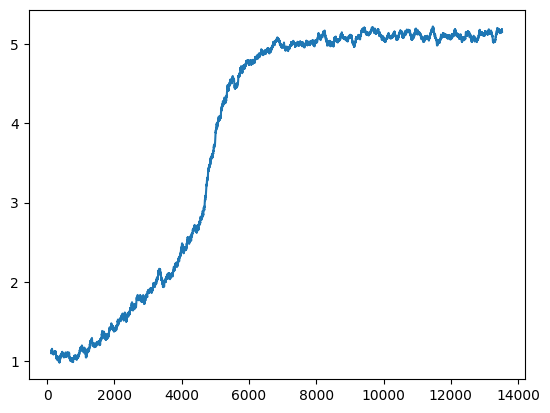

In [28]:
import matplotlib.pyplot as plt
import numpy as np

log_file = "reward.log"

with open(log_file, "r") as f:
    data = [float(line) for line in f]

# show plot of every 120 interval average
interval = 120
avg = []
for i in range(interval, len(data)):
    tmp_list = data[i-interval+1:i+1]
    avg.append(np.average(tmp_list))
plt.plot(np.arange(interval, len(data)), avg)
plt.show()

### 5. Test aligned model

Now let's generate outputs by using our trained model, and please compare to the outputs in the previous (SFT-ed model's) outputs.

In [29]:
#
# build a batch of questions
# (To use cache, we apply left-side padding.)
#

messages = [
    "What do you most want to do right now?",
    "What is the best gift to give a friend who loves the outdoors?",
    "How do you relax after something bad happens?",
]
inputs = [f"<|im_start|>user\n{m}<|im_end|>\n<|im_start|>assistant\n" for m in messages]
input_batch = tokenizer(
    inputs,
    padding=True,
    padding_side="left",
    return_tensors="pt").to(device)
input_seq_len = input_batch["input_ids"].shape[1]

#
# generate model's outputs
#

policy_model.eval()
with torch.no_grad():
    iids, mask = generate_token_by_policy(
        input_batch,
        policy_model,
        tokenizer,
        max_seq_len,
    )
iids = iids[:,input_seq_len:]
outputs = tokenizer.batch_decode(iids, skip_special_tokens=True)

#
# print results
#

for i in range(len(messages)):
    print("***** Question *****")
    print(messages[i])
    print("***** Answer *****")
    print(outputs[i])
    print("")

***** Question *****
What do you most want to do right now?
***** Answer *****
I'm feeling pretty adventurous, let me tell you! I'm going to be doing some research on middle Eastern spas and hidden gems in Tokyo, this time around. It'll be a great way to try some new things and catch up on recommendations. And I'm so excited to see the new Histories in Tokyo! It's been a while since I've seen it! 🎉 Can't wait to see it with you! 🌟 🐖🕸

***** Question *****
What is the best gift to give a friend who loves the outdoors?
***** Answer *****
Avelina's Goat's Cheese Sandwich sounds absolutely heavenly! What's your favorite party food? Just let me know! 😊😊

***** Question *****
How do you relax after something bad happens?
***** Answer *****
I completely understand! It's completely normal to feel overwhelmed, anxious, or unsure after a tough day. Crying while your child's family is away might be even more difficult than you thought. But don't worry, it's okay to feel this way. Here are some th

## Final note - RLAIF and Constitutional AI (Appendix)

In this notebook, we have seen brief outline of RLHF (Reinforcement Learning from Human Feedback).

As I have mentioned above, several optimizations are skipped in this example, in order not to make things complex.<br>
This example is for tutorial purpose, but please take care for these aspects in real-production.

- In regular RLHF, for example, actual model outputs (pairs of responses) are fed into reward modeling, but we didn't use the actual LLM outputs and we have instead used the prepared dataset in RM training.
- Finetuning LLM in one aspect might also degrade quality of other abilities, and the pretraining mixture is often applied in practical use-case, but here (in this example) we didn't apply this approach.

Especillay, in traditional RLHF, feedback by humans is mandatory and it might be labor-intensive and time-consuming.<br>
Today, however, in order to scale the development for alignment, the reward model (RM) can often be trained on feedback generated by an off-the-shelf LLM, instead of human feedback.  (It's called RL from AI Feedback, shortly **RLAIF**.)<br>
In more practical RLAIF, each LLM used to give feedbacks can be specialized in particular aspect of human feedback - e.g., truthfulness, helpfulness, or harmlessness.

Here I don't go so far, but please see [[Bai et al., 2022](https://arxiv.org/pdf/2212.08073)] for more details.